In [1]:
import torch
print(torch.__version__)


2.5.1+cu121


In [2]:
# Install PyTorch Geometric dependencies compatible with PyTorch 2.5.1 and CUDA 12.1
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.5.1+cu121.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.5.1+cu121.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.5.1+cu121.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-2.5.1+cu121.html

# Install the main PyTorch Geometric package
!pip install torch-geometric


Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 19.5 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 30.4 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 24.6 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.8/994.8 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.8 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import UPFD
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_max_pool as gmp
from torch.nn import Linear
from sklearn.metrics import accuracy_score, f1_score
from transformers import AutoTokenizer, AutoModel
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [4]:
# Load the UPFD dataset
dataset_name = "gossipcop"
train_data = UPFD(root=".", name=dataset_name, feature="content", split="train")
test_data = UPFD(root=".", name=dataset_name, feature="content", split="test")
print("Train Samples: ", len(train_data))
print("Test Samples: ", len(test_data))

Extracting ./gossipcop/raw/data.zip
Processing...
Done!


Train Samples:  1092
Test Samples:  3826


In [5]:
# Visualize a sample graph
sample_id = 1
def visualize_graph(data):
    G = nx.DiGraph()
    edge_index = data.edge_index.numpy()
    for i in range(edge_index.shape[1]):
        G.add_edge(edge_index[0, i], edge_index[1, i])
    nx.draw(G, with_labels=True)
    plt.show()

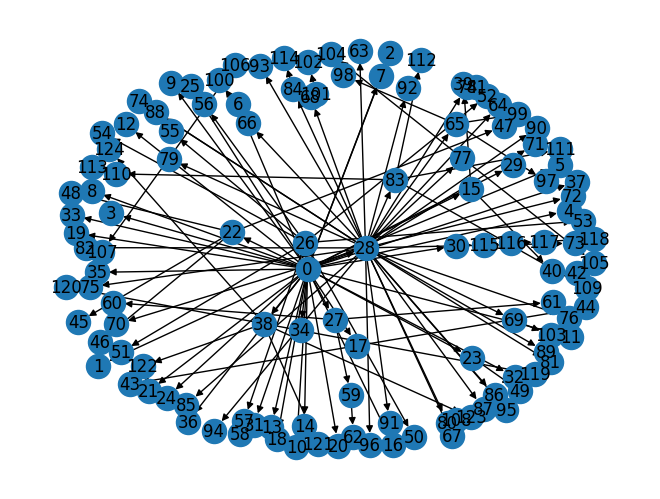

In [6]:
visualize_graph(train_data[sample_id])

Training set - Fake: 557, Real: 535
Test set - Fake: 1910, Real: 1916


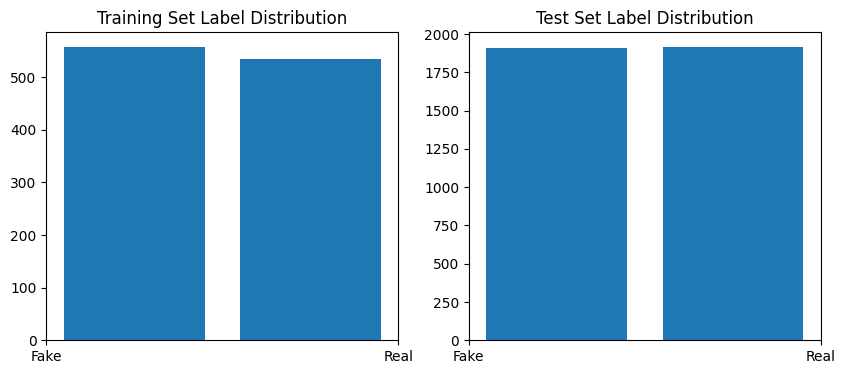

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Count label distribution in training and test sets
train_labels = [data.y.item() for data in train_data]
test_labels = [data.y.item() for data in test_data]

# Print counts
train_fake = np.sum(np.array(train_labels) == 0)
train_real = np.sum(np.array(train_labels) == 1)
test_fake = np.sum(np.array(test_labels) == 0)
test_real = np.sum(np.array(test_labels) == 1)

print(f"Training set - Fake: {train_fake}, Real: {train_real}")
print(f"Test set - Fake: {test_fake}, Real: {test_real}")

# Plot distributions
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(train_labels, bins=2, rwidth=0.8)
plt.xticks([0, 1], ["Fake", "Real"])
plt.title("Training Set Label Distribution")

plt.subplot(1, 2, 2)
plt.hist(test_labels, bins=2, rwidth=0.8)
plt.xticks([0, 1], ["Fake", "Real"])
plt.title("Test Set Label Distribution")

plt.show()


In [8]:
# Extract unique news IDs from train and test sets
train_ids = set([data.x.numpy().tobytes() for data in train_data])  # Convert tensors to bytes for set comparison
test_ids = set([data.x.numpy().tobytes() for data in test_data])

# Check for overlap
overlap = train_ids.intersection(test_ids)
print(f"Number of overlapping samples: {len(overlap)}")


Number of overlapping samples: 8


In [9]:
import numpy as np
from sklearn.model_selection import train_test_split

# Convert data objects to unique identifiers
all_data = train_data + test_data
unique_ids = np.array([data.x.numpy().tobytes() for data in all_data])  # Use feature tensors as unique IDs

# Get unique indices
_, unique_indices = np.unique(unique_ids, return_index=True)
unique_data = [all_data[i] for i in unique_indices]  # Extract only unique samples

# Perform train-test split again (80% train, 20% test)
train_data, test_data = train_test_split(unique_data, test_size=0.2, random_state=42)

# Verify again that there's NO overlap
train_ids = set([data.x.numpy().tobytes() for data in train_data])
test_ids = set([data.x.numpy().tobytes() for data in test_data])
overlap = train_ids.intersection(test_ids)

# Print results
print(f"Final Training Samples: {len(train_data)}")
print(f"Final Testing Samples: {len(test_data)}")
print(f"Final Number of Overlapping Samples: {len(overlap)}")  # Should be 0!


Final Training Samples: 3906
Final Testing Samples: 977
Final Number of Overlapping Samples: 0


Training set - Fake: 1970, Real: 1936
Test set - Fake: 495, Real: 482


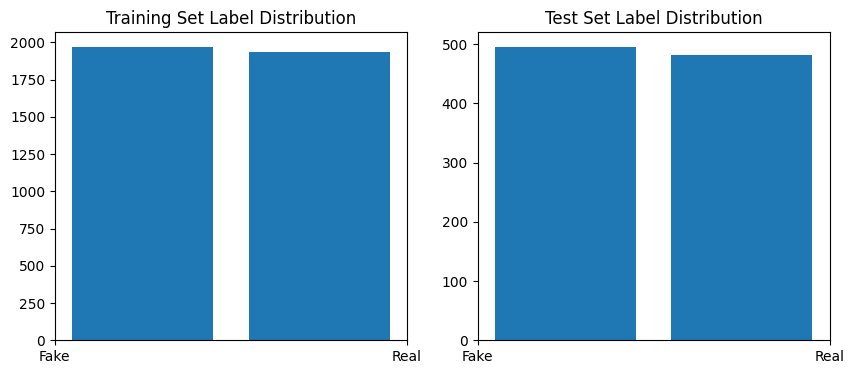

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Count label distribution in training and test sets
train_labels = [data.y.item() for data in train_data]
test_labels = [data.y.item() for data in test_data]

# Print counts
train_fake = np.sum(np.array(train_labels) == 0)
train_real = np.sum(np.array(train_labels) == 1)
test_fake = np.sum(np.array(test_labels) == 0)
test_real = np.sum(np.array(test_labels) == 1)

print(f"Training set - Fake: {train_fake}, Real: {train_real}")
print(f"Test set - Fake: {test_fake}, Real: {test_real}")

# Plot distributions
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(train_labels, bins=2, rwidth=0.8)
plt.xticks([0, 1], ["Fake", "Real"])
plt.title("Training Set Label Distribution")

plt.subplot(1, 2, 2)
plt.hist(test_labels, bins=2, rwidth=0.8)
plt.xticks([0, 1], ["Fake", "Real"])
plt.title("Test Set Label Distribution")

plt.show()


In [17]:
print(train_data[0])


Data(x=[79, 310], edge_index=[2, 78], y=[1])


In [18]:
for data in train_data:
    degrees = torch.bincount(data.edge_index[0], minlength=data.x.shape[0])
    data.credibility_scores = (degrees.float() / degrees.max()).view(-1, 1)  # Normalize scores

for data in test_data:
    degrees = torch.bincount(data.edge_index[0], minlength=data.x.shape[0])
    data.credibility_scores = (degrees.float() / degrees.max()).view(-1, 1)


In [21]:
# Import necessary libraries
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_max_pool as gmp, GATConv
from torch.nn import Linear
from sklearn.metrics import accuracy_score, f1_score
from transformers import AutoTokenizer, AutoModel
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Ensure dataset is correctly split
num_features = train_data[0].num_features  # Extract feature size from first sample

# Create DataLoaders with the corrected split
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

# Define the FPN-GCN model (Fake News Propagation Graph Convolutional Network)
import torch.nn as nn

class FPN_GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_heads=4):
        super(FPN_GCN, self).__init__()

        # GCN Layers for Graph Feature Extraction
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)

        # Multi-Hop Propagation Attention (Capturing multi-layer spread of fake news)
        self.multi_hop_attention = GATConv(hidden_channels, hidden_channels, heads=num_heads, concat=False)

        # Credibility Score Embedding
        self.credibility_fc = Linear(1, hidden_channels)  # Fixed to map credibility scores correctly

        # Fully Connected Layers for Classification
        self.lin1 = nn.Linear(hidden_channels, hidden_channels)
        self.lin2 = nn.Linear(hidden_channels, out_channels)

        self.dropout = nn.Dropout(0.2)

    def forward(self, x, edge_index, credibility_scores, batch):
        # GCN Layers for Initial Feature Extraction
        h = self.conv1(x, edge_index).relu()
        h = self.conv2(h, edge_index).relu()

        # Apply Multi-Hop Attention to capture propagation evolution
        h = self.multi_hop_attention(h, edge_index).relu()

        # Ensure credibility_scores is not None and correctly shaped
        if credibility_scores is None or credibility_scores.shape[0] != h.shape[0]:
            credibility_scores = torch.zeros((h.shape[0], 1), device=h.device)  # Default to zero

        credibility_embeddings = self.credibility_fc(credibility_scores)  # Transform credibility scores to match hidden size
        h = h + credibility_embeddings  # Integrating credibility scores into node representations

        # Pooling to get graph-level features
        h = gmp(h, batch)

        # Fully Connected Layers for Classification
        h = self.lin1(h).relu()
        h = self.dropout(h)
        out = self.lin2(h)

        return torch.sigmoid(out)  # Binary classification (Fake or Real)


# Initialize model with correct feature size
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FPN_GCN(num_features, 128, 1).to(device)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.0005)
loss_fnc = torch.nn.BCELoss()

# Training and testing functions
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)

        # Ensure credibility_scores exists
        credibility_scores = getattr(data, "credibility_scores", None)

        optimizer.zero_grad()
        out = model(data.x, data.edge_index, credibility_scores, data.batch)
        loss = loss_fnc(torch.reshape(out, (-1,)), data.y.float())
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
    return total_loss / len(train_loader.dataset)

@torch.no_grad()
def test():
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    for data in test_loader:
        data = data.to(device)

        # Ensure credibility_scores exists
        credibility_scores = getattr(data, "credibility_scores", None)

        out = model(data.x, data.edge_index, credibility_scores, data.batch)
        loss = loss_fnc(torch.reshape(out, (-1,)), data.y.float())
        total_loss += float(loss) * data.num_graphs
        all_preds.append(torch.reshape(out, (-1,)))
        all_labels.append(data.y.float())
    accuracy, f1 = calculate_metrics(all_preds, all_labels)
    return total_loss / len(test_loader.dataset), accuracy, f1

# Metric calculation
def calculate_metrics(preds, gts):
    preds = torch.cat(preds).cpu().numpy()
    gts = torch.cat(gts).cpu().numpy()
    preds = np.round(preds)
    acc = accuracy_score(gts, preds)
    f1 = f1_score(gts, preds)
    return acc, f1

# Initialize lists to store metrics
train_losses = []
test_losses = []
test_accs = []  # Store test accuracy
test_f1s = []   # Store test F1 score

for epoch in range(40):  # Adjust if needed
    train_loss = train()
    test_loss, test_acc, test_f1 = test()

    # Store losses and metrics for analysis
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    test_accs.append(test_acc)  # Collect accuracy
    test_f1s.append(test_f1)    # Collect F1 score

    print(f"Epoch {epoch+1:02d}: TrainLoss={train_loss:.4f}, TestLoss={test_loss:.4f}, TestAcc={test_acc:.4f}, TestF1={test_f1:.4f}")

# Analyze predictions on test set
for data in test_loader:
    data = data.to(device)

    # Ensure credibility_scores exists
    credibility_scores = getattr(data, "credibility_scores", None)

    pred = model(data.x, data.edge_index, credibility_scores, data.batch)
    df = pd.DataFrame({
        "pred_logit": pred.detach().numpy()[:, 0],
        "pred": torch.round(pred).detach().numpy()[:, 0],
        "true": data.y.numpy()
    })
    print(df.head(10))
    break


Epoch 01: TrainLoss=0.6958, TestLoss=0.6914, TestAcc=0.5067, TestF1=0.0000
Epoch 02: TrainLoss=0.6908, TestLoss=0.6846, TestAcc=0.4964, TestF1=0.6621
Epoch 03: TrainLoss=0.6805, TestLoss=0.6860, TestAcc=0.4933, TestF1=0.6607
Epoch 04: TrainLoss=0.6417, TestLoss=0.5870, TestAcc=0.6888, TestF1=0.7595
Epoch 05: TrainLoss=0.4668, TestLoss=0.3048, TestAcc=0.9181, TestF1=0.9182
Epoch 06: TrainLoss=0.2570, TestLoss=0.1893, TestAcc=0.9335, TestF1=0.9324
Epoch 07: TrainLoss=0.1991, TestLoss=0.2182, TestAcc=0.9171, TestF1=0.9207
Epoch 08: TrainLoss=0.2126, TestLoss=0.1614, TestAcc=0.9447, TestF1=0.9428
Epoch 09: TrainLoss=0.1678, TestLoss=0.1814, TestAcc=0.9314, TestF1=0.9273
Epoch 10: TrainLoss=0.1513, TestLoss=0.1419, TestAcc=0.9550, TestF1=0.9540
Epoch 11: TrainLoss=0.1757, TestLoss=0.1421, TestAcc=0.9591, TestF1=0.9588
Epoch 12: TrainLoss=0.1388, TestLoss=0.1353, TestAcc=0.9611, TestF1=0.9608
Epoch 13: TrainLoss=0.1354, TestLoss=0.1383, TestAcc=0.9570, TestF1=0.9571
Epoch 14: TrainLoss=0.131

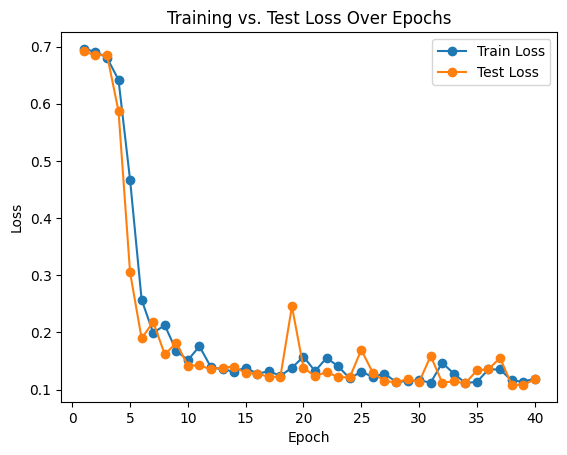

In [22]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.plot(epochs, train_losses, label="Train Loss", marker="o")
plt.plot(epochs, test_losses, label="Test Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs. Test Loss Over Epochs")
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


In [25]:
@torch.no_grad()
def evaluate_model():
    model.eval()
    all_preds = []
    all_labels = []

    for data in test_loader:
        data = data.to(device)

        # Ensure credibility_scores exists
        credibility_scores = getattr(data, "credibility_scores", None)

        out = model(data.x, data.edge_index, credibility_scores, data.batch)
        preds = torch.round(out).cpu().numpy()
        labels = data.y.cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)

    return all_preds, all_labels


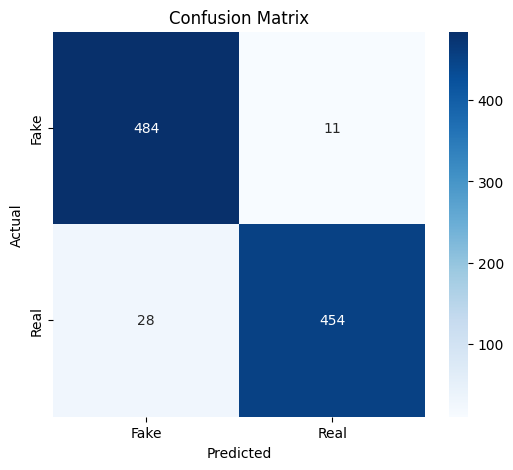

In [26]:
# Get predictions and true labels
y_pred, y_true = evaluate_model()

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [27]:
# Print classification report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=['Fake', 'Real']))


Classification Report:
               precision    recall  f1-score   support

        Fake       0.95      0.98      0.96       495
        Real       0.98      0.94      0.96       482

    accuracy                           0.96       977
   macro avg       0.96      0.96      0.96       977
weighted avg       0.96      0.96      0.96       977

